#  Fitting Spectrum

This notebook shows the aplication of fitting code to a 5-component spectrum 


In [44]:
import matplotlib.pylab as plt
import scipy.optimize as sop
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
from copy import deepcopy
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
Cathode = [b'CARRIER_PLATE',
           b'ENCLOSURE_BODY',
           b'ENCLOSURE_WINDOW',
           b'PMT_BASE',
           b'OPTICAL_PAD',
           b'PMT_BODY',
           b'CATHODE']
Anode   = [b'DB_PLUG',
           b'DICE_BOARD',
           b'ANODE_QUARTZ',
           b'EXTRA_VESSEL',
           b'SUPPORT_PLATE']
Barrel  = [b'DRIFT_TUBE',
           b'SHIELDING_STRUCT',
           b'VESSEL',
           b'ICS',
           b'PEDESTAL',
           b'HDPE_TUBE',
           b'SHIELDING_STEEL',
           b'SHIELDING_LEAD']

In [3]:
def SigmaEstimator(E, rlim = 0.01):
    #res en Q_bb
    qbb = 2458     #MeV

    return rlim*(qbb*E)**0.5/2.35482

def Gaussianizator(E,sigma = -1, rlim = 0.01):
    if sigma<0:
        sigma = SigmaEstimator(E, rlim)
    return np.random.normal(E, sigma)


def h_Gauss(h,sigma = -1, rlim = 0.01):
    nbin = h.nbin
    minE = h.minlim
    maxE = h.maxlim
    hnew = hist([],nbin,minE,maxE)
    hnew.hist = np.zeros_like(h.hist)
    hnew.bins = h.bins[:]

    for i in range(nbin):
        Caux = h.bins[i]
        naux = h.hist[i]
        for j in range(int(naux)):
            hnew.Fill_hist(Gaussianizator(Caux, sigma, rlim))
    return hnew

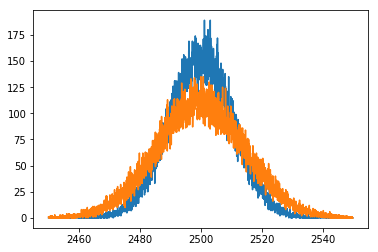

In [4]:
mean = 2500

h_  = hist(mean*np.ones(100000),mean, mean-50,mean+50)
#plt.plot(h_.bins, h_.hist)

h__ = h_Gauss(h_, -1, 0.01)
plt.plot(h__.bins, h__.hist)

h___ = h_Gauss(h__, 10, 0.01)
plt.plot(h___.bins, h___.hist)

In [5]:
def bkg_nevt(days, rate=2.6e-3):
    
    sec = days * 24 * 3600
    
    return sec * rate 

def signal_rate(days, halflife=2.165e21, fid=0):
    """
    R    = 198.
    Z    = 532.
    Nav  = 6.022e23
    Rgas = 0.082
    P    = 10.2
    T    = 298.15
    V    = np.pi * (R - fid)**2 * (Z - 2 * fid)
    V   *= 1e-6
    n    = P * V / (Rgas * T)
    N    = n * Nav * 0.91
    print(V)
    rate = halflife * 365.15
    rate = np.log(2) / rate
    """
    #return N * days * rate 
    return days/210.602/365.25 * 164519


# MC true info

In [6]:
MC_f     = tb.open_file("../Data/MC_true_total_run4b.h5", "r")
MC_table = pd.DataFrame.from_records(MC_f.root.dataframe.table.read())
MC_table.tail()

,index,evt_number,atomic_number,mass_number,region
1249084,1249084,543503072,19,40,b'DICE_BOARD'
1249085,1249085,619700009,81,208,b'SHIELDING_STRUCT'
1249086,1249086,240650268,27,60,b'VESSEL'
1249087,1249087,543503074,19,40,b'DICE_BOARD'
1249088,1249088,740700324,81,208,b'EXTRA_VESSEL'


In [7]:
regions  = MC_table.region     .unique()
isotopes = MC_table.mass_number.unique()

In [8]:
index_K  = MC_table.mass_number==40 
index_Co = MC_table.mass_number==60
index_Bi = MC_table.mass_number==214
index_Tl = MC_table.mass_number==208
index_bb = MC_table.mass_number==136

In [9]:
index_K_regions  = {} 
index_Co_regions = {} 
index_Bi_regions = {} 
index_Tl_regions = {} 
index_bb_regions = {} 

In [10]:
for region in regions:
    index_K_regions[region]  = MC_table[index_K] .region == region
    index_Co_regions[region] = MC_table[index_Co].region == region
    index_Bi_regions[region] = MC_table[index_Bi].region == region
    index_Tl_regions[region] = MC_table[index_Tl].region == region
    index_bb_regions[region] = MC_table[index_bb].region == region

In [11]:
evtn_K_regions  = {} 
evtn_Co_regions = {} 
evtn_Bi_regions = {} 
evtn_Tl_regions = {} 
evtn_bb_regions = {} 

In [12]:
for region in regions:
    evtn_K_regions[region]  = MC_table[index_K ][index_K_regions [region]].evt_number
    evtn_Co_regions[region] = MC_table[index_Co][index_Co_regions[region]].evt_number
    evtn_Bi_regions[region] = MC_table[index_Bi][index_Bi_regions[region]].evt_number
    evtn_Tl_regions[region] = MC_table[index_Tl][index_Tl_regions[region]].evt_number
    evtn_bb_regions[region] = MC_table[index_bb][index_bb_regions[region]].evt_number

# Bkg  construction

In [199]:
f_bkg     = tb.open_file("../Data/hits_fid_MC_bkg_1hitpersipm_voxel-drop.h5", "r")
table_bkg = pd.DataFrame.from_records(f_bkg.root.dataframe.table.read())
table_bkg.tail()
f_bkg.close()

In [200]:
table_bkg

,index,evt_energy,numb_of_tracks,energy,length,numb_of_voxels,eblob1,eblob2,eblob1_bary,eblob2_bary,...,maxR,event,x_blob_1,y_blob_1,z_blob_1,x_blob_2,y_blob_2,z_blob_2,subindex,dist_blobs
0,28,1048.853691,1,1048.853691,66.344490,13,279.158332,111.146683,332.241550,111.146683,...,165.680415,190000000,-157.435438,15.756214,204.307024,-141.044156,-37.343089,191.040789,0,57.133205
1,30,1242.590731,2,116.610120,13.333333,2,116.610120,116.610120,116.610120,116.610120,...,171.026314,209600000,10.640730,-55.000000,37.563432,13.475853,-44.519427,37.024895,0,10.870619
2,31,1242.590731,2,1125.980611,68.882930,24,351.968323,333.626463,443.727509,352.049714,...,171.026314,209600000,126.588207,-105.000000,60.337685,103.330136,-55.000000,52.073853,1,55.760459
3,46,2096.025936,1,2096.025936,148.751188,56,350.901771,301.800452,438.719815,225.044725,...,163.248277,640000003,-77.079077,135.000000,225.240416,-112.837215,41.163368,238.382669,0,101.275252
4,48,1594.889067,2,586.632266,71.885850,10,252.300744,194.089347,203.225197,194.089347,...,66.708320,742250002,17.747617,-55.000000,374.537501,-20.395488,-23.133965,412.170075,0,62.342211
5,49,1594.889067,2,1008.256801,53.033009,18,253.772647,96.354521,396.866141,157.030272,...,66.708320,742250002,-15.000000,-25.000000,332.089646,15.000000,-55.000000,331.910719,1,42.426784
6,53,789.055015,1,789.055015,47.843978,11,492.253708,209.920555,492.253708,209.920555,...,151.162165,70000008,-82.808593,61.827266,452.640105,-116.604326,78.367405,435.510136,0,41.342031
7,61,1074.569106,1,1074.569106,58.337602,17,380.087766,311.668967,432.291213,311.668967,...,129.807550,260000002,115.000000,-45.000000,144.666747,93.714321,-3.835110,131.032122,0,48.306638
8,65,792.262467,1,792.262467,55.112854,18,412.638974,209.494712,459.584305,215.829562,...,149.833241,540000003,-127.203259,44.626586,319.228261,-93.893202,77.073019,308.173664,0,47.796810
9,68,1168.497202,1,1168.497202,52.995966,21,444.346662,279.623714,471.203921,368.139767,...,141.598023,242500007,55.000000,84.035286,121.124595,86.174250,105.000000,108.837336,0,39.526319


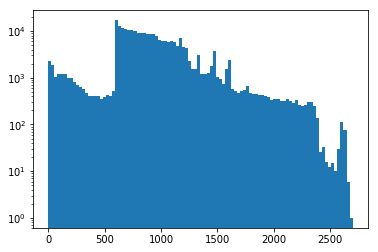

In [201]:
plt.hist(table_bkg.energy,100,[0,2700]);
plt.yscale('log')

In [202]:
evt_K_regions  = {} 
evt_Co_regions = {} 
evt_Bi_regions = {} 
evt_Tl_regions = {} 
evt_bb_regions = {} 

In [203]:
def custom_concat(list_):
    if list_:
        return pd.concat(list_, ignore_index=True)
    else:
        return []

In [204]:
for region in regions:
    print(region)
    evt_K_regions[region]  = custom_concat([table_bkg[table_bkg.event==evt] for evt in evtn_K_regions[region] .values])
    evt_Co_regions[region] = custom_concat([table_bkg[table_bkg.event==evt] for evt in evtn_Co_regions[region].values])
    evt_Bi_regions[region] = custom_concat([table_bkg[table_bkg.event==evt] for evt in evtn_Bi_regions[region].values])
    evt_Tl_regions[region] = custom_concat([table_bkg[table_bkg.event==evt] for evt in evtn_Tl_regions[region].values])

b'PMT_BASE'
b'DRIFT_TUBE'
b'SHIELDING_STRUCT'
b'DICE_BOARD'
b'ANODE_QUARTZ'
b'VESSEL'
b'EXTRA_VESSEL'
b'PMT_BODY'
b'ICS'
b'PEDESTAL'
b'CARRIER_PLATE'
b'SHIELDING_LEAD'
b'ENCLOSURE_WINDOW'
b'SUPPORT_PLATE'
b'HDPE_TUBE'
b'OPTICAL_PAD'
b'DB_PLUG'
b'ACTIVE'
b'SHIELDING_STEEL'
b'ENCLOSURE_BODY'


In [205]:
aux = {'Anode':[], 'Barrel':[], 'Cathode':[]}

evt_K_ABC  = deepcopy(aux)
evt_Co_ABC = deepcopy(aux) 
evt_Bi_ABC = deepcopy(aux) 
evt_Tl_ABC = deepcopy(aux)

In [206]:
for region in Cathode:
    print(region)
    if region in regions:
        print('ok')
        evt_K_ABC ['Cathode'].append(evt_K_regions [region])
        evt_Co_ABC['Cathode'].append(evt_Co_regions[region])
        evt_Bi_ABC['Cathode'].append(evt_Bi_regions[region])
        evt_Tl_ABC['Cathode'].append(evt_Tl_regions[region])
    else:
        print('not simulated')    

for region in Barrel:
    print(region)
    if region in regions:
        print('ok')
        evt_K_ABC ['Barrel'].append(evt_K_regions [region])
        evt_Co_ABC['Barrel'].append(evt_Co_regions[region])
        evt_Bi_ABC['Barrel'].append(evt_Bi_regions[region])
        evt_Tl_ABC['Barrel'].append(evt_Tl_regions[region])

for region in Anode:
    print(region)
    if region in regions:
        print('ok')
        evt_K_ABC ['Anode'].append(evt_K_regions [region])
        evt_Co_ABC['Anode'].append(evt_Co_regions[region])
        evt_Bi_ABC['Anode'].append(evt_Bi_regions[region])
        evt_Tl_ABC['Anode'].append(evt_Tl_regions[region])

b'CARRIER_PLATE'
ok
b'ENCLOSURE_BODY'
ok
b'ENCLOSURE_WINDOW'
ok
b'PMT_BASE'
ok
b'OPTICAL_PAD'
ok
b'PMT_BODY'
ok
b'CATHODE'
not simulated
b'DRIFT_TUBE'
ok
b'SHIELDING_STRUCT'
ok
b'VESSEL'
ok
b'ICS'
ok
b'PEDESTAL'
ok
b'HDPE_TUBE'
ok
b'SHIELDING_STEEL'
ok
b'SHIELDING_LEAD'
ok
b'DB_PLUG'
ok
b'DICE_BOARD'
ok
b'ANODE_QUARTZ'
ok
b'EXTRA_VESSEL'
ok
b'SUPPORT_PLATE'
ok


In [207]:
for part in list(aux.keys()):
    evt_K_ABC [part] = pd.concat(evt_K_ABC [part])
    evt_Co_ABC[part] = pd.concat(evt_Co_ABC[part]) 
    evt_Bi_ABC[part] = pd.concat(evt_Bi_ABC[part]) 
    evt_Tl_ABC[part] = pd.concat(evt_Tl_ABC[part])

In [208]:
pd.Series()

Series([], dtype: float64)

In [209]:
for part in list(aux.keys()):
    evt_K_ABC [part]['region'] = pd.Series(part, evt_K_ABC [part].index)
    evt_Co_ABC[part]['region'] = pd.Series(part, evt_Co_ABC[part].index) 
    evt_Bi_ABC[part]['region'] = pd.Series(part, evt_Bi_ABC[part].index) 
    evt_Tl_ABC[part]['region'] = pd.Series(part, evt_Tl_ABC[part].index)

In [210]:
for part in list(aux.keys()):
    evt_K_ABC [part]['isotope'] = pd.Series('K' , evt_K_ABC [part].index)
    evt_Co_ABC[part]['isotope'] = pd.Series('Co', evt_Co_ABC[part].index) 
    evt_Bi_ABC[part]['isotope'] = pd.Series('Bo', evt_Bi_ABC[part].index) 
    evt_Tl_ABC[part]['isotope'] = pd.Series('Tl', evt_Tl_ABC[part].index)

# Signal construction

In [36]:
f_sig     = tb.open_file("../Data/hits_fid_MC_signal_1hitpersipm_voxel-drop.h5", "r")
table_sig = pd.DataFrame.from_records(f_sig.root.dataframe.table.read())
table_sig.tail()

,index,evt_energy,numb_of_tracks,energy,length,numb_of_voxels,eblob1,eblob2,eblob1_bary,eblob2_bary,...,maxR,event,x_blob_1,y_blob_1,z_blob_1,x_blob_2,y_blob_2,z_blob_2,subindex,dist_blobs
164515,488541,1038.678079,1,1038.678079,54.681342,29,333.508558,289.052646,391.896880,347.016768,...,87.464278,780078981,-25.000000,-65.000000,183.460622,-55.602824,-34.467154,192.471101,0,44.158535
164516,488546,857.027840,1,857.027840,34.855702,11,666.527421,441.073659,675.030837,519.129456,...,158.902486,780078986,123.916463,-66.327067,418.227197,136.893130,-44.362478,410.378138,0,26.691661
164517,488548,1235.559866,1,1235.559866,58.576873,20,405.436865,327.586558,450.451268,327.586558,...,60.415230,780078988,-46.389882,13.193067,443.868632,-2.559875,47.068792,435.906809,0,55.964497
164518,488553,1013.111424,1,1013.111424,53.033009,25,398.434307,300.692649,398.434307,348.850534,...,173.925271,780078997,-55.846607,158.647717,174.138579,-25.000000,123.146237,182.458194,0,47.760697
164519,488554,1239.616330,1,1239.616330,51.023598,23,462.225700,440.052279,552.730176,450.755615,...,157.003185,780078999,-115.000000,75.000000,223.107650,-82.083009,96.299918,229.446552,0,39.716451


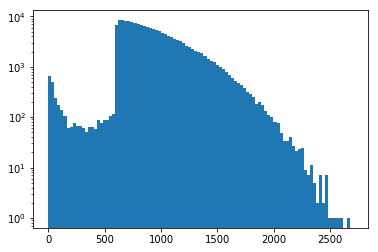

In [37]:
plt.hist(table_sig.energy,100,[0,2700]);
plt.yscale('log')

# Saving PDFs

In [213]:
name_out = os.path.expandvars("$Datadir")+"/pdf_bkg_fid.h5"
file_out = tb.open_file(name_out, "w")
print(file_out)
file_out.close()

/Users/brais/Documents/NEXT/Next_Energy/Data/pdf_bkg_fid.h5 (File) ''
Last modif.: 'Wed Jan 30 16:59:17 2019'
Object Tree: 
/ (RootGroup) ''



In [214]:
for part in list(aux.keys()):
    for name, isotope in [['K', evt_K_ABC], ['Co', evt_Co_ABC], ['Bi', evt_Bi_ABC], ['Tl', evt_Tl_ABC]]:
        table = isotope[part]
        if "index" in table: del table["index"]
        table.to_hdf(name_out, key=part, mode='a',
                     format  = "table", data_columns = True ,
                     complib = "zlib" , complevel    = 4,
                     append=True)
        file_out = tb.open_file(name_out, "r+")
        group = getattr(file_out.root, part)
        file_out.rename_node(group.table, name)
        file_out.close()
    

In [215]:
file_out.close()

In [216]:
file_out = tb.open_file(name_out, "r+")
print(file_out)
file_out.close()

/Users/brais/Documents/NEXT/Next_Energy/Data/pdf_bkg_fid.h5 (File) ''
Last modif.: 'Wed Jan 30 16:59:35 2019'
Object Tree: 
/ (RootGroup) ''
/Anode (Group) ''
/Anode/Bi (Table(13667,), shuffle, zlib(4)) ''
/Anode/Co (Table(3009,), shuffle, zlib(4)) ''
/Anode/K (Table(41312,), shuffle, zlib(4)) ''
/Anode/Tl (Table(17398,), shuffle, zlib(4)) ''
/Barrel (Group) ''
/Barrel/Bi (Table(39601,), shuffle, zlib(4)) ''
/Barrel/Co (Table(59070,), shuffle, zlib(4)) ''
/Barrel/K (Table(25041,), shuffle, zlib(4)) ''
/Barrel/Tl (Table(17111,), shuffle, zlib(4)) ''
/Cathode (Group) ''
/Cathode/Bi (Table(3991,), shuffle, zlib(4)) ''
/Cathode/Co (Table(18750,), shuffle, zlib(4)) ''
/Cathode/K (Table(5018,), shuffle, zlib(4)) ''
/Cathode/Tl (Table(10149,), shuffle, zlib(4)) ''

